# Time Series Project
## Climate Change in Chicago
### Natasha Rivers
#### July 9, 2021

<hr style="border:2px solid black"> </hr>

In [1]:
#imports
import pandas as pd
import numpy as np

#stats modules
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error
from math import sqrt

#visualization
import matplotlib.pyplot as plt

#datetime utilities
from datetime import timedelta, datetime

#custom scripts
import acquire
import prepare

#remove warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

## Executive Summary
- My best performing model was rolling average (period = 3)
- 

| model	                | rmse	   | temperature
|-----------------------|----------|--------------|
| Last Observed Value	| 6.53170  |	11.70
| Simple Average	    | 6.52801  | 11.12
| Rolling Average	    | 6.52581  | 11.55

<hr style="border:2px solid black"> </hr>

# Plan

- acquire file from Kaggle
- Prepare
- create visuals in Evaluate
- model
- Takeaways

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
#use pandas to read in CSV
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')

In [3]:
#take a look
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


### Takeaways from Acquire:
- used pandas to read in the csv for Major City

<hr style="border:2px solid black"> </hr>

# Prepare

In [4]:
#check for nulls, datatypes and and df shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             239177 non-null  object 
 1   AverageTemperature             228175 non-null  float64
 2   AverageTemperatureUncertainty  228175 non-null  float64
 3   City                           239177 non-null  object 
 4   Country                        239177 non-null  object 
 5   Latitude                       239177 non-null  object 
 6   Longitude                      239177 non-null  object 
dtypes: float64(2), object(5)
memory usage: 12.8+ MB


In [5]:
#take a look at all cities and pick one
df.City.unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome', 'São Paulo',
       'S

In [6]:
#chose the best city in the world
#set df to ONLY Madrid
df = df.loc[df['City'] == 'Madrid']

In [7]:
#check for nulls in new df
df.isnull().sum()

dt                                0
AverageTemperature               73
AverageTemperatureUncertainty    73
City                              0
Country                           0
Latitude                          0
Longitude                         0
dtype: int64

In [8]:
#check shape of new df
df.shape

(3239, 7)

In [9]:
#73 is only 2% of 3239- will just drop nulls
#set df to drop nas
df = df.dropna()

In [10]:
#look at new shape (-73 nulls)
df.shape

(3166, 7)

In [11]:
#confirm no nulls
df.isnull().sum()

dt                               0
AverageTemperature               0
AverageTemperatureUncertainty    0
City                             0
Country                          0
Latitude                         0
Longitude                        0
dtype: int64

In [12]:
#change dtype of 'dt'
#check current dtype- object
df.dt.dtypes

dtype('O')

In [13]:
#change data types
df.dt = df.dt.astype('datetime64[ns]')

In [14]:
#confirm dtype was changed
df.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
City                                     object
Country                                  object
Latitude                                 object
Longitude                                object
dtype: object

In [15]:
#check current index
type(df.index)

pandas.core.indexes.numeric.Int64Index

In [16]:
#set index and sort
df = df.set_index('dt').sort_index()

In [17]:
#confirm index changed
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [18]:
#create column to identify month!
df['month'] = df.index.month_name()

In [19]:
#create column to identify month!
df['day_of_week'] = df.index.day_name()

In [20]:
#create column to identify month!
df['year'] = df.index.year

In [21]:
#create column that has temp in fahrenheit
df['Average_Temp_F'] = (df['AverageTemperature'] * 9/5) + 32

In [22]:
df.head()

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,day_of_week,year,Average_Temp_F
dt,,,,,,,,,,
1743-11-01,6.652,2.015,Madrid,Spain,40.99N,4.26W,November,Friday,1743,43.9736
1744-04-01,11.189,2.170,Madrid,Spain,40.99N,4.26W,April,Wednesday,1744,52.1402
1744-05-01,12.241,2.098,Madrid,Spain,40.99N,4.26W,May,Friday,1744,54.0338
1744-06-01,17.756,2.051,Madrid,Spain,40.99N,4.26W,June,Monday,1744,63.9608
1744-07-01,20.848,1.874,Madrid,Spain,40.99N,4.26W,July,Wednesday,1744,69.5264


### Takeaways from Prepare:
- dropped all null values
- selected only Madrid, Spain as major city
- changed object type of 'dt' to be a datetime64[ns]
- reset index to 'dt'
- re-sort by index
- created a column with month name
- created a column with the weekday name
- created a column with year 
- created a column with temp in fahrenheit

<hr style="border:2px solid black"> </hr>

# Explore

### Split Data
- using percentage-based split

In [23]:
#set train to 50% of total
train_size = int(len(df) * 0.5)
train_size

1583

In [24]:
#set validate to 30% of total
validate_size = int(len(df) * 0.3)
validate_size

949

In [25]:
#set test is remaining amount
test_size = int(len(df) - train_size - validate_size)
test_size

634

In [26]:
validate_end_index = train_size + validate_size
validate_end_index

2532

In [27]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [28]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,month,day_of_week,year,Average_Temp_F
dt,,,,,,,,,,
1960-10-01,9.552,0.296,Madrid,Spain,40.99N,4.26W,October,Saturday,1960,49.1936
1960-11-01,7.367,0.323,Madrid,Spain,40.99N,4.26W,November,Tuesday,1960,45.2606


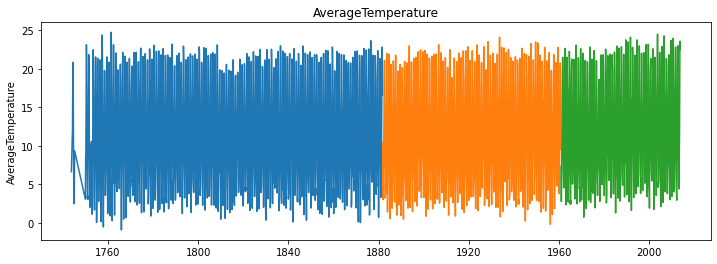

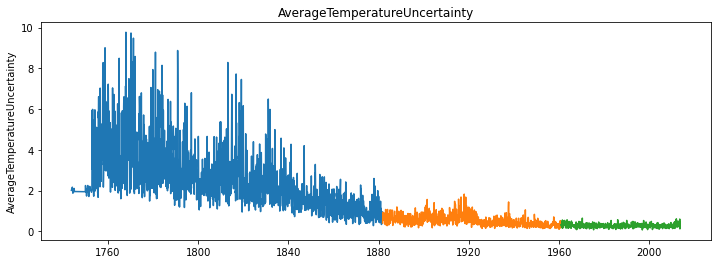

In [29]:
#visualize distribution
for col in train.columns.tolist()[0:2]:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Visualize

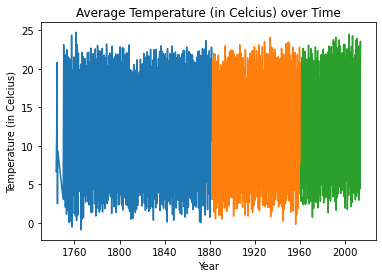

In [30]:
#plot train with target of average temp
plt.plot(train.index, train.AverageTemperature)
#plot test with target of average temp 
plt.plot(validate.index, validate.AverageTemperature)
#plot test with target of average temp 
plt.plot(test.index, test.AverageTemperature)

plt.title('Average Temperature (in Celcius) over Time')

plt.ylabel('Temperature (in Celcius)')
plt.xlabel('Year')

None

In [31]:
#set y to the target variable
y = train.AverageTemperature.resample('M').mean()
y.head()

dt
1743-11-30    6.652
1743-12-31      NaN
1744-01-31      NaN
1744-02-29      NaN
1744-03-31      NaN
Freq: M, Name: AverageTemperature, dtype: float64

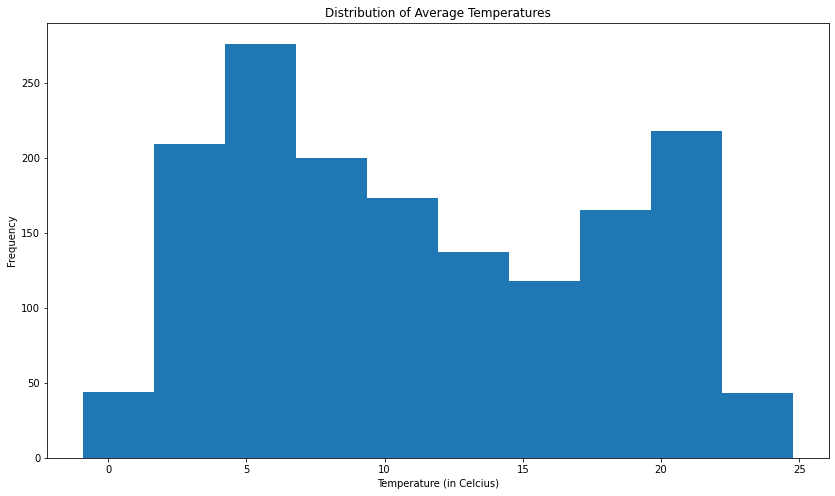

In [32]:
#plot distribution of target variable
plt.figure(figsize=(14, 8))
y.plot.hist()
plt.title('Distribution of Average Temperatures')
plt.xlabel('Temperature (in Celcius)')
None

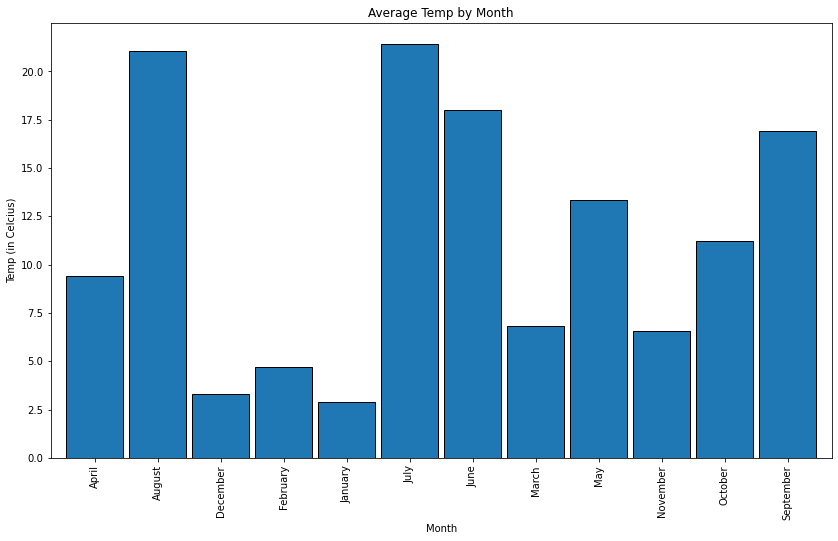

In [33]:
#graph average monthly temperature
plt.figure(figsize=(14, 8))
ax = y.groupby(y.index.month_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Temp by Month', xlabel='Month', ylabel='Temp (in Celcius)')
None

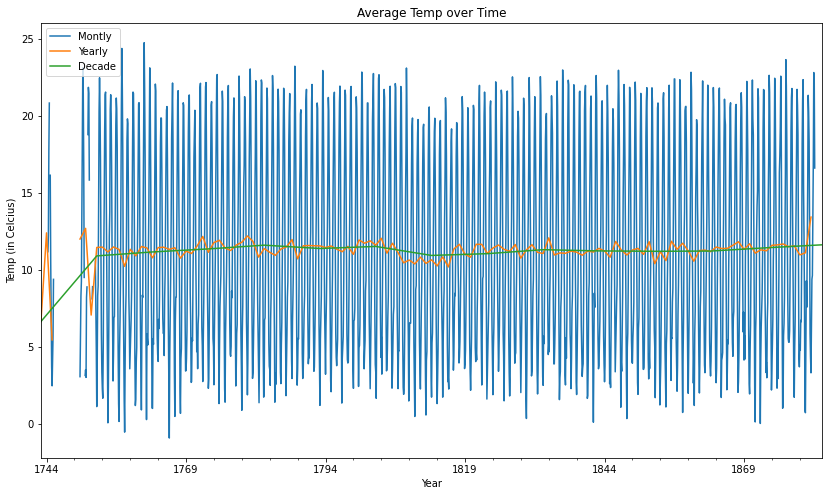

In [34]:
#look at temp over time, monthly/yearly
plt.figure(figsize=(14, 8))
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
y.resample('10Y').mean().plot(label='Decade')
plt.title('Average Temp over Time')
plt.xlabel('Year')
plt.ylabel('Temp (in Celcius)')
plt.legend()

None

In [35]:
y = train.AverageTemperature.resample('10Y').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

,y,trend,seasonal,resid
dt,,,,
1743-12-31,6.652000,6.652000,0.0,0.0
1753-12-31,10.917184,10.917184,0.0,0.0
1763-12-31,11.174383,11.174383,0.0,0.0
1773-12-31,11.370167,11.370167,0.0,0.0
1783-12-31,11.614192,11.614192,0.0,0.0


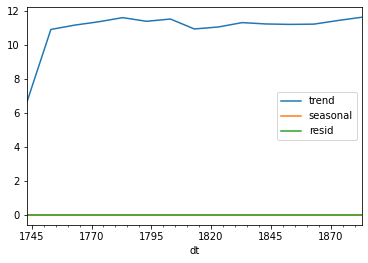

In [36]:
decomposition.iloc[:, 1:].plot()
None

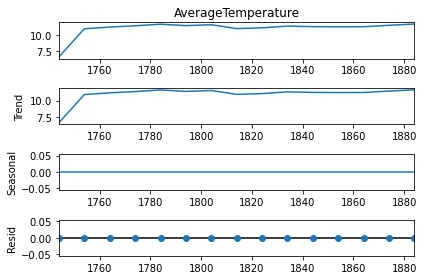

In [37]:
# the value returned from seasonal_decompose can itself be plotted
result.plot()
None

### Lag Plot

Text(0.5, 1.0, 'Lag plot with lag=1')

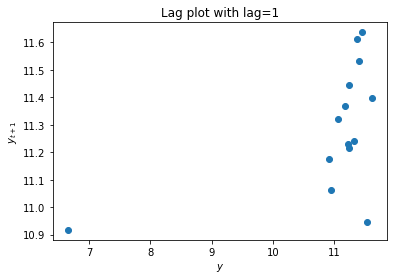

In [38]:
#Lag Plot
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

,this_5_years,AverageTemperatureUncertainty,year,Average_Temp_F,next_5_years
dt,,,,,
1743-12-31,6.652000,2.015000,1743.000000,43.973600,10.094750
1748-12-31,10.094750,2.030667,1744.333333,50.170550,11.183919
1753-12-31,11.183919,2.430135,1751.513514,52.131054,11.145867
1758-12-31,11.145867,4.092883,1756.000000,52.062560,11.202900
1763-12-31,11.202900,4.017717,1761.000000,52.165220,11.299833


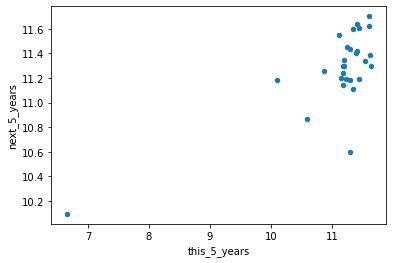

In [39]:
#resample to every 5 years, aggregate by mean
fiveyears = train.resample('5Y').mean()
#create column by next five years- lagplot to next 5 years
fiveyears['next_5_years'] = fiveyears.AverageTemperature.shift(-1)
#rename column
fiveyears = fiveyears.rename(columns={'AverageTemperature': 'this_5_years'})
#plot this period with next period
fiveyears.plot.scatter(x='this_5_years', y='next_5_years')
fiveyears.head()

In [40]:
train = train.resample('5Y').mean()
# create a categorical feature
train['Temperature_bin'] = pd.qcut(train.AverageTemperature, 3, labels=['High Temp', 'Average Temp', 'Low Temp'])
train.groupby('Temperature_bin').mean()

,AverageTemperature,AverageTemperatureUncertainty,year,Average_Temp_F
Temperature_bin,,,,
High Temp,10.522345,2.406797,1800.584685,50.940221
Average Temp,11.296919,2.496285,1816.555556,52.334453
Low Temp,11.544185,2.448751,1816.390909,52.779534


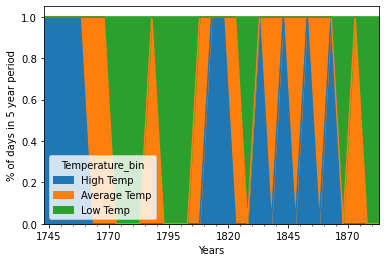

In [41]:
(train.groupby('Temperature_bin')
 .resample('5Y')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in 5 year period')
plt.xlabel('Years')
None

### Takeaways from Explore
- Temperature uncertainty decreased overtime
    - this could be due to technology- 
        - possible over time, the temperature was more accuratly recorded 
- August and July appear to have the highest average temperatures
- January and December have the lowest average temperatures

<hr style="border:2px solid black"> </hr>

# Modeling

In [42]:
def make_predictions(temp):
    yhat_df = pd.DataFrame({'AverageTemperature': [temp]}, 
                       index = validate.index)
    return yhat_df

In [43]:
#take the last average temp in average temp - round 2 decimal places
last_observed = round(train['AverageTemperature'][-1:][0], 2)
last_observed

11.7

In [44]:
#plot and evaluate 
def plot_and_eval(yhat_df, target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(yhat_df, target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [45]:
#yhat has same index as validate
#define yhat
last_df = pd.DataFrame({'AverageTemperature': [last_observed]}, 
                       index = validate.index)

last_df.head(2)

,AverageTemperature
dt,
1881-10-01,11.7
1881-11-01,11.7


In [46]:
yhat_df_lo = make_predictions(last_observed)
yhat_df_lo

,AverageTemperature
dt,
1881-10-01,11.7
1881-11-01,11.7
1881-12-01,11.7
1882-01-01,11.7
1882-02-01,11.7
...,...
1960-06-01,11.7
1960-07-01,11.7
1960-08-01,11.7


In [47]:
target_var = 'AverageTemperature'

In [48]:
rmse_last = round(sqrt(mean_squared_error(validate[target_var], yhat_df_lo[target_var])), 5)

In [49]:
#create a dataframe to make data easier to visualize/understand
model_df = pd.DataFrame(data=[{
    'model': 'Last Observed Value',
    'rmse': rmse_last,
    'temperature': last_observed
    }])

model_df

,model,rmse,temperature
0,Last Observed Value,6.5317,11.7


______________________

## Simple Average Model

In [51]:
simple_average = round(train['AverageTemperature'].mean(), 2)

In [52]:
yhat_df_simple = make_predictions(simple_average)

In [53]:
rmse_simple = round(sqrt(mean_squared_error(validate[target_var], yhat_df_simple[target_var])), 5)

In [54]:
#create visual to see baseline vs LinearRegression model
model_df = model_df.append(
    {
    'model': 'Simple Average',
    'rmse': rmse_simple,
    'temperature': simple_average},
    ignore_index= True
    )

model_df

,model,rmse,temperature
0,Last Observed Value,6.53170,11.70
1,Simple Average,6.52801,11.12


_______________________________________

### Rolling/Moving Average Model

In [55]:
# compute a 3 months rolling average 
period = 3
rolling_average = round(train['AverageTemperature'].rolling(period).mean().iloc[-1], 2)

In [56]:
yhat_df_rolling = make_predictions(rolling_average)
yhat_df_rolling.head(3)

,AverageTemperature
dt,
1881-10-01,11.55
1881-11-01,11.55
1881-12-01,11.55


In [57]:
rmse_rolling = round(sqrt(mean_squared_error(validate[target_var], yhat_df_rolling[target_var])), 5)

In [58]:
#create visual to see baseline vs LinearRegression model
model_df = model_df.append(
    {
    'model': 'Rolling Average',
    'rmse': rmse_rolling,
    'temperature': rolling_average},
    ignore_index= True
    )

model_df

,model,rmse,temperature
0,Last Observed Value,6.53170,11.70
1,Simple Average,6.52801,11.12
2,Rolling Average,6.52581,11.55


### Takeaways from Modeling
- rolling averages model performed the best with an RMSE of 6.52581

| model	                | rmse	   | temperature
|-----------------------|----------|--------------|
| Last Observed Value	| 6.53170  |	11.70
| Simple Average	    | 6.52801  | 11.12
| Rolling Average	    | 6.52581  | 11.55

<hr style="border:2px solid black"> </hr>

## Final Takeaways & Next Steps:
- rolling average (with a period of 3) performed best as a model

<br>

- With more time:
    - I would like to look further into 'Average Temperature Uncertainty'